In [1]:
from pathlib import Path
import shutil
import random

from concurrent.futures import ThreadPoolExecutor

In [2]:
def convert_yolo_annotationsfrom_CVAT_to_ultralytics_format(directory_with_CVAT_yolo_annotations):
    '''
    Convert annotations in yolo format to the recommended ultralytics format
    
    '''
    directory_with_CVAT_yolo_annotations = Path(directory_with_CVAT_yolo_annotations) / 'obj_train_data'

    file_names_with_annotations = [fn.with_suffix('') for fn in directory_with_CVAT_yolo_annotations.glob('*.txt') if fn.stat().st_size > 0]

    # Shuffle the filenames to ensure randomness
    random.shuffle(file_names_with_annotations)
    
    # Split the data
    train_split = int(0.8 * len(file_names_with_annotations))
    val_split = int(0.1 * len(file_names_with_annotations)) + train_split
    
    train_files = file_names_with_annotations[:train_split]
    val_files = file_names_with_annotations[train_split:val_split]
    test_files = file_names_with_annotations[val_split:]

    #copy images
    ultralytics_yolo_root_dir = directory_with_CVAT_yolo_annotations.parent / 'ultralytics_yolo'
    ultralytics_yolo_images_dir = ultralytics_yolo_root_dir / f'images'
    ultralytics_yolo_labels_dir = ultralytics_yolo_root_dir / f'labels'

    shutil.rmtree(ultralytics_yolo_root_dir, ignore_errors=True)
    ultralytics_yolo_root_dir.mkdir()
    ultralytics_yolo_images_dir.mkdir()
    ultralytics_yolo_labels_dir.mkdir()

    for split_name, split_files in zip(['train', 'test', 'val'], [train_files, test_files, val_files]):

        #copy images
        images_split_dir = ultralytics_yolo_images_dir / f'{split_name}'
        images_split_dir.mkdir()
        
        images_file_paths = [fn.with_suffix('.PNG') for fn in split_files]

        with ThreadPoolExecutor() as executor:
            
            [executor.submit(shutil.copy, fn, images_split_dir) for fn in images_file_paths]
        

        #copy labels
        labels_split_dir = ultralytics_yolo_labels_dir / f'{split_name}'
        labels_split_dir.mkdir()
        
        labels_file_paths = [fn.with_suffix('.txt') for fn in split_files]

        with ThreadPoolExecutor() as executor:
            
            [executor.submit(shutil.copy, fn, labels_split_dir) for fn in labels_file_paths]

    #copy classes
    original_classes_file_path = directory_with_CVAT_yolo_annotations.parent / 'obj.names'
    new_classes_file_path = ultralytics_yolo_root_dir / 'classes.txt'

    shutil.copy(original_classes_file_path, new_classes_file_path)

    return 

In [3]:
directory_with_CVAT_yolo_annotations = '/mnt/d/projects/cjgea/datasets/annotated/task13'
convert_yolo_annotationsfrom_CVAT_to_ultralytics_format(directory_with_CVAT_yolo_annotations)

In [1]:
# from PIL import Image
# from PIL import ImageEnhance
# from pathlib import Path
# from concurrent.futures import ThreadPoolExecutor

# def resize_images(fp, fp_new):

#     with Image.open(fp) as im:

#         enhancer = ImageEnhance.Contrast(im)

#         enhanced_img = enhancer.enhance(1.5)
        
#         enhanced_img.resize((128,128)).save(fp_new)


# in_dir = Path('/mnt/d/projects/benthic-megafauna-detector/runs/detect/predict10/crops/Fish')

# out_dir = Path('/mnt/d/projects/benthic-megafauna-detector/runs/detect/predict10/crops/fish_resized')

# with ThreadPoolExecutor() as executor:
    
#     [executor.submit(resize_images, (in_dir / fp.name), (out_dir / fp.name)) for fp in in_dir.iterdir()]

In [1]:
import json

In [2]:
fp = 'datasets/Elpidia_heckeri_TEST/annotations.json'

with open(fp, 'r') as file:
    
    data = json.load(file)

In [5]:
data.keys()

dict_keys(['images', 'annotations', 'categories'])

In [8]:
import json5

# Load the COCO JSON file
with open(fp, 'r') as file:
    coco_data = json5.load(file)

# Extract unique class labels
class_names = {category['id']: category['name'] for category in coco_data['categories']}

# Write the class labels to classes.txt
with open('classes.txt', 'w') as file:
    for class_id in sorted(class_names.keys()):
        file.write(f"{class_names[class_id]}\n")

# Process and convert to YOLO format with normalization
for image in coco_data['images']:
    image_id = image['id']
    image_name = image['file_name']
    img_width = image['width']
    img_height = image['height']

    # Open a separate file for each image
    with open(f"{image_name.split('.')[0]}.txt", 'w') as img_file:
        for annotation in coco_data['annotations']:
            if annotation['image_id'] == image_id:
                class_id = annotation['category_id']
                bbox = annotation['bbox']
                x_center = (bbox[0] + bbox[2] / 2) / img_width
                y_center = (bbox[1] + bbox[3] / 2) / img_height
                width = bbox[2] / img_width
                height = bbox[3] / img_height
                img_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

print("Normalization, conversion, and class extraction complete!")


Normalization, conversion, and class extraction complete!


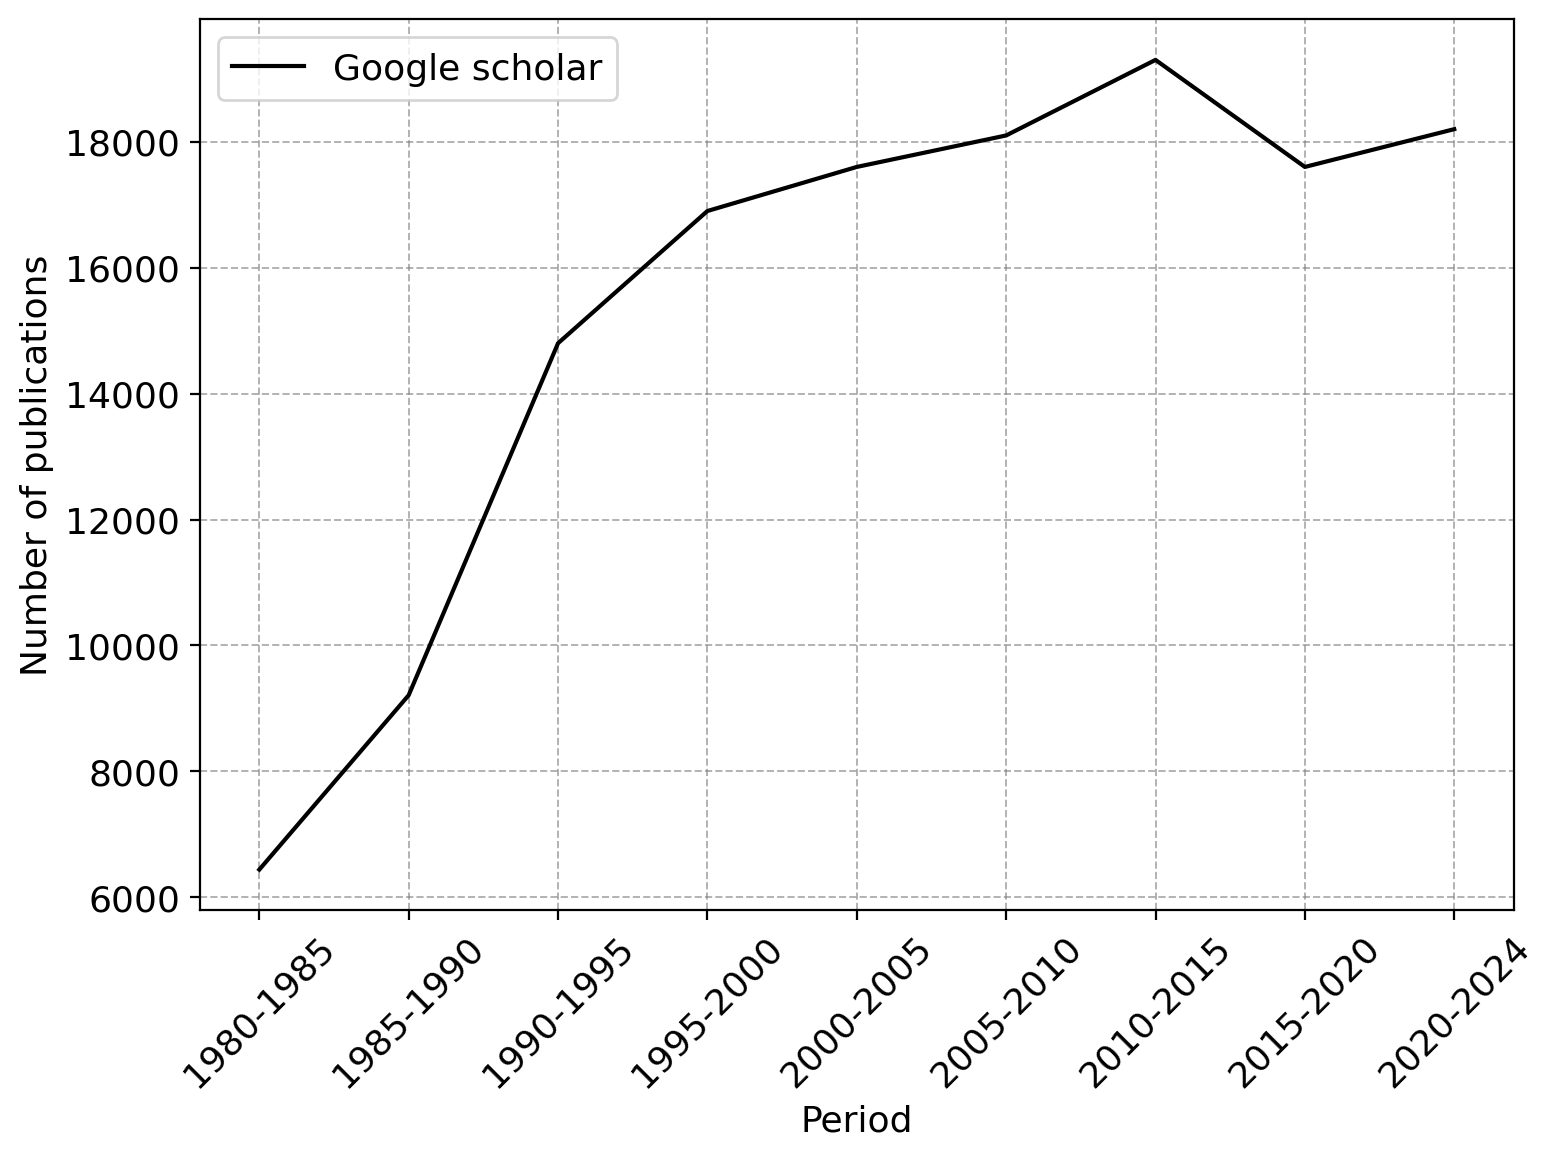

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("husl")

plt.rcParams.update({'font.size': 13})

%matplotlib inline
%config InlineBackend.figure_format='retina'

time = ['1980-1985', '1985-1990', '1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015', '2015-2020', '2020-2024']
counts = [6440, 9210, 14800, 16900, 17600, 18100, 19300, 17600, 18200]

data = pd.DataFrame({'period':time, 'Google scholar':counts})

fig, ax = plt.subplots(figsize=(8,6))

data.plot(x='period', y='Google scholar', kind='line', ax=ax, rot=45, color='black')

ax.grid(True, linestyle='--', linewidth=0.7, color='gray', alpha=0.6)

ax.set_xlabel(xlabel='Period', fontfamily='sans-serif')

ax.set_ylabel(ylabel='Number of publications', fontfamily='sans-serif')

plt.tight_layout()

plt.savefig('publication_trend.png', dpi=300, bbox_inches='tight')